In [0]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 7, 4
import seaborn as sns

from scipy import stats
from scipy.stats import norm, skew

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

In [0]:
# Read data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

# Drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

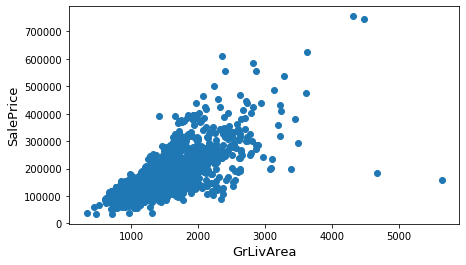

In [0]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

In [0]:
train = train.drop(train[(train['GrLivArea']>4000) & 
                         (train['SalePrice']<300000)].index)

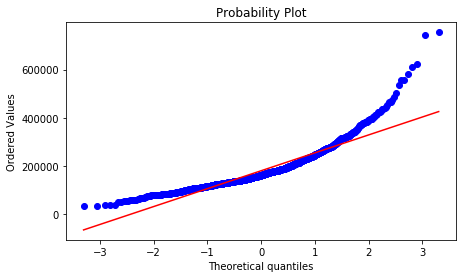

In [0]:
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

If the original data follows a log-normal distribution or approximately so, then the log-transformed data follows a normal or near normal distribution. In this case, the log-transformation does remove or reduce skewness.

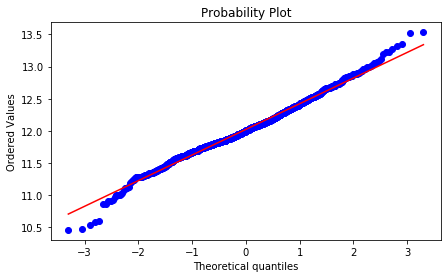

In [0]:
# Log-transformation of the target variable
# We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])

fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

In [0]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)


In [0]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' : all_data_na})

In [0]:
missing_data.head()

,Missing Ratio
PoolQC,99.691
MiscFeature,96.400
Alley,93.212
Fence,80.425
FireplaceQu,48.680


In [0]:
# NaN means no "object" in all of the following cases
# We thus replace it with a None value
no_object_features = ["PoolQC","MiscFeature","Alley","Fence","FireplaceQu",
             "GarageType", "GarageFinish", "GarageQual", "GarageCond",
             "MasVnrType",'BsmtQual', 'BsmtCond', 'BsmtExposure',
              'BsmtFinType1', 'BsmtFinType2','MSSubClass']
for feature in no_object_features:
  all_data[feature] = all_data[feature].fillna('None')

In [0]:
zero_object_features = ['GarageYrBlt', 'GarageArea', 'GarageCars',
                        'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF',
                        'BsmtFullBath', 'BsmtHalfBath',
                         "MasVnrArea"]
for feature in zero_object_features:
  all_data[feature] = all_data[feature].fillna(0)

In [0]:
# Group by neighborhood and fill in missing value 
# by the median LotFrontage of all the neighborhood
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

In [0]:
all_data = all_data.drop(['Utilities'], axis=1)
all_data["Functional"] = all_data["Functional"].fillna("Typ")
# The following only have one missing value
one_nan_features = ['MSZoning','Electrical','KitchenQual',
                    'Exterior1st','Exterior2nd','SaleType']
for feature in one_nan_features:
  all_data[feature] = all_data[feature].fillna(all_data[feature].mode()[0])

In [0]:
#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


In [0]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)
#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [0]:
# Adding total sqfootage feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

In [0]:
features = all_data.columns.values
numeric_feats = []
categoric = []
for col in features:
    if all_data[col].dtype == 'object':
        categoric.append(col)
    else:
        numeric_feats.append(col)

In [0]:
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(5)


Skew in numerical features: 



,Skew
MiscVal,21.940
PoolArea,17.689
LotArea,13.109
LowQualFinSF,12.085
3SsnPorch,11.372


In [0]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)

There are 33 skewed numerical features to Box Cox transform


In [0]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2917, 338)


In [0]:
train = all_data[:ntrain]
test = all_data[ntrain:]

# Modeling

In [0]:
from sklearn import linear_model
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import cross_val_score, GridSearchCV
import xgboost as xgb
import pickle

In [0]:
def compute_rmse(model):
  rmse = np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error"))
  return rmse

In [0]:
def compute_prediction(model):
  return np.expm1(model.predict(test)).flatten()

In [0]:
def get_submission(model, filename="submission.csv"):
  pred = np.zeros((len(test),len(model)))
  for m in range(len(model)):
    pred[:,m] = compute_prediction(model[m])
  sub = pd.DataFrame()
  sub['Id'] = test_ID
  sub['SalePrice'] = np.mean(pred, axis=1)
  sub.to_csv(filename, index=False)

### Elastic Net - Baseline

In [0]:
ENet = make_pipeline(RobustScaler(), linear_model.ElasticNetCV(
    l1_ratio=[.1, .5, .7, .9, .95, .99, 1],
    n_jobs=-1))

In [0]:
ENet.fit(train, y_train)

### Partial Least Squares

In [0]:
PLS = PLSRegression(n_components=5).fit(train, y_train)
# n_components param was tuned with CV

Achieved 0.127 RMSE on test-data with combination of the 2

### Gradient Boosting Regressor

In [0]:
# # Run once, then save the model.
#  parameters = {
#     "loss": ["huber"],
#     # "learning_rate": [0.085, 0.1, 0.15],
#     "min_samples_split": np.linspace(0.1, 0.5, 5),
#     # "min_samples_leaf": np.linspace(0.1, 0.5, 5),
#     "max_depth": [2,3,4],
#     "max_features": ["sqrt"],
#     "criterion": ["friedman_mse"],
#     # "subsample": [0.8, 0.9, 1.0],
#     "n_estimators": [400, 450, 500]
#     }
# GBoost = GridSearchCV(GradientBoostingRegressor(), parameters,
#                       cv=5, n_jobs=-1, verbose=2)
# GBoost.fit(train, y_train)
# filename = 'GBoost_housing.sav'
# pickle.dump(GBoost, open(filename, 'wb'))

In [0]:
filename = 'GBoost_housing.sav'
GBoost = pickle.load(open(filename, 'rb'))

#### Submission

In [0]:
get_submission([PLS, ENet, GBoost], "sub_comb.csv")

RMSE improved to 0.124 when including GBoost

### Future work: XGBoost

In [0]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [0]:
model_xgb.fit(train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4603, gamma=0.0468,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=3, min_child_weight=1.7817, missing=None,
             n_estimators=2200, n_jobs=1, nthread=-1, objective='reg:linear',
             random_state=7, reg_alpha=0.464, reg_lambda=0.8571,
             scale_pos_weight=1, seed=None, silent=1, subsample=0.5213,
             verbosity=1)